# Pokemon Type Prediction with CNN and Keras
## Group 3 
### Brian Fan, Ryan Stofer, Ellen Burrell, Yuer Hao

## 0. Load and Check Data
Note that the `tensorflow` packages are for our CNN model creation, `pandas` and `numpy` for data frame manipulation, `matplotlib` and `seaborn` for visualization, and `os` for file directory usage.

In [3]:
import IPython
from IPython.display import display
import tensorflow as tf
from tensorflow import keras as ks
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.style as stl
stl.use("ggplot")
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

#### First of all, let's look at our dataset
Note: If you wish to load the data yourself, please change the `pd.read_csv()` command so it points to the correct path of your downloaded `.csv` file

In [4]:
# Import the dataset containing info for 809 pokemons
pokemon = pd.read_csv('data/pokemon.csv')

# Sort the dataset by pokemon's name alphabetically and reassign the index
pokemon = pokemon.sort_values(by=['Name'], 
                              ascending=True).reset_index(drop=True)

In [5]:
# Check the basic info of the dataset
display(pokemon.head())
display(pokemon.describe())
display(pokemon['Type1'].unique())

,Name,Type1,Type2
0,abomasnow,Grass,Ice
1,abra,Psychic,NaN
2,absol,Dark,NaN
3,accelgor,Bug,NaN
4,aegislash-blade,Steel,Ghost


,Name,Type1,Type2
count,809,809,405
unique,809,18,18
top,abomasnow,Water,Flying
freq,1,114,95


array(['Grass', 'Psychic', 'Dark', 'Bug', 'Steel', 'Rock', 'Normal',
       'Water', 'Dragon', 'Electric', 'Poison', 'Fire', 'Fairy', 'Ice',
       'Ground', 'Ghost', 'Fighting', 'Flying'], dtype=object)

#### About this Dataset
##### - Name: Name of each pokemon
##### - Type 1: Each pokemon has a type, this determines weakness/resistance to attacks
##### - Type 2: Some pokemon are dual type and have 2
##### Based on the data display, we know the dataset contains 809 Pokemons with 18 different type. Most of their main type are water. 

#### Then, Let's check epecially how many pokemon belong to each class (Type of Pokemon)

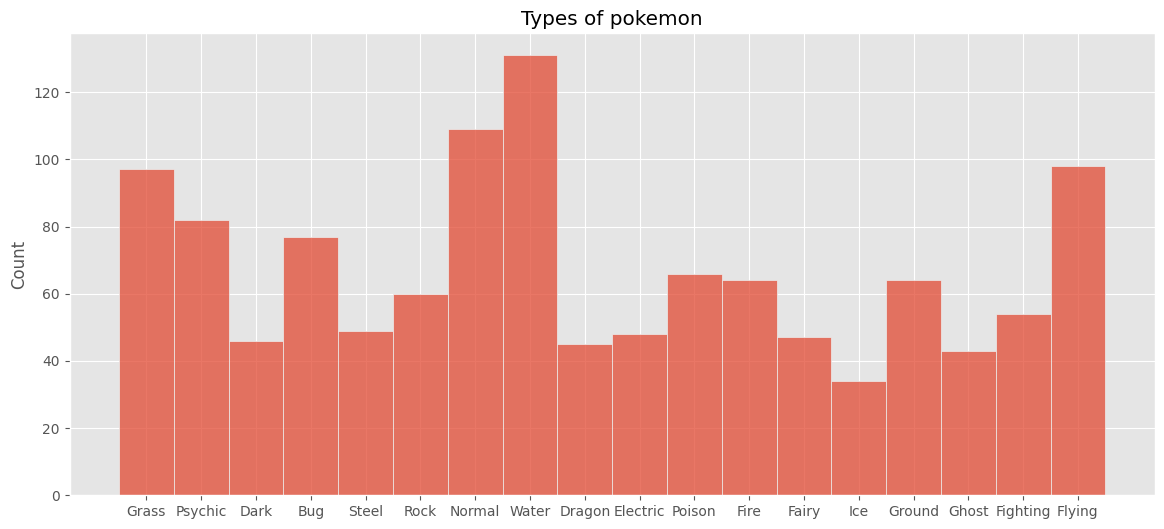

In [6]:
# Make a list of all pokemon types based on Type1 and Type2 columns
X=pokemon['Type1'].tolist()+pokemon["Type2"].tolist()

# Plot the types and their corresponding counts
plt.figure(figsize=(14, 6))
sns.histplot(x=X)
plt.title('Types of pokemon')
plt.show()

We notice that most types have roughly the same amount, except for Water and Normal, which have the highest recorded values.

## 1. Testing Images Reading
We run a quick for loop to plot example images of 5 different pokemon titled with its associated name.

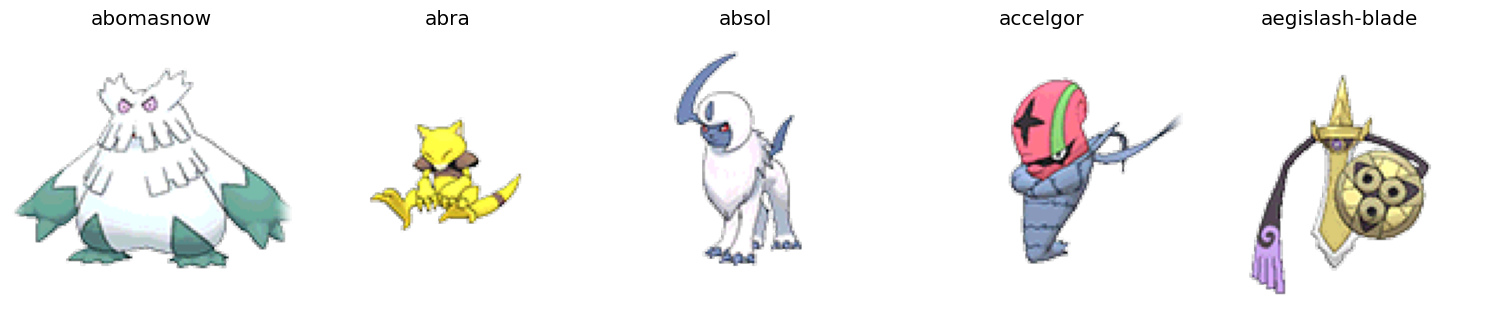

In [7]:
import matplotlib.image as mpimg
# Specify the path to image folder on the local computer. Modify it to user's discretion
path = "data/images/"

# Specify the number of plots and how we want it to be displayed
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 8)) 
ax = [ax1, ax2, ax3, ax4, ax5]

# This for loop retrieves the path to the first 5 images and plot
for i in range(5):
    img = mpimg.imread(path+pokemon['Name'][i]+'.png')
    ax[i].imshow(img)
    ax[i].set_title(pokemon['Name'][i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

We now store the file paths for each pokemon image and create a new column for our dataframe, `path`.

In [8]:
# Get all images' names in the image folder
nameOfImage = sorted(os.listdir(path))

# Initialize an empty list to store path to each image
pathOfImage = []
for i in nameOfImage:
    pathOfImage.append(path + i)

# Add a new column in the pokemon dataset with paths
pokemon['path'] = pathOfImage

We double check to make sure that all 809 pokemon images are intact.

In [9]:
count = pokemon.shape[0]
count

809

#### Keep only Grass, Fire, Water
For the sake of our computational resources, we choose to create a 4 class multinomial as we are running our CNN on a CPU. We categorize each pokemon by type and lump all other classes as `Other`.

In [10]:
# Initialize an empty list to store revised type of each pokemon
Type = []

# We want only "Grass", "Fire", and "Water" and will classify all other types as "other"
for i in range(count):
    if (pokemon.iloc[i]['Type1']=='Grass') or (pokemon.iloc[i]['Type2']=='Grass'):
        Type.append('Grass')
    elif (pokemon.iloc[i]['Type1']=='Water') or (pokemon.iloc[i]['Type2']=='Water'):
        Type.append('Water')
    elif (pokemon.iloc[i]['Type1']=='Fire') or (pokemon.iloc[i]['Type2']=='Fire'):
        Type.append('Fire')
    else:
        Type.append('Other')

pokemon["type"]=Type
pokemon = pokemon.drop(['Type1', 'Type2'], axis=1)

In [11]:
pokemon.head(10)

,Name,path,type
0,abomasnow,data/images/abomasnow.png,Grass
1,abra,data/images/abra.png,Other
2,absol,data/images/absol.png,Other
3,accelgor,data/images/accelgor.png,Other
4,aegislash-blade,data/images/aegislash-blade.png,Other
5,aerodactyl,data/images/aerodactyl.png,Other
6,aggron,data/images/aggron.png,Other
7,aipom,data/images/aipom.png,Other
8,alakazam,data/images/alakazam.png,Other
9,alomomola,data/images/alomomola.png,Water


In [12]:
pokemon.to_csv('pokemon_revised.csv')

Here is the new distribution of our data after lumping all other classes:

Text(0, 0.5, 'Number of images')

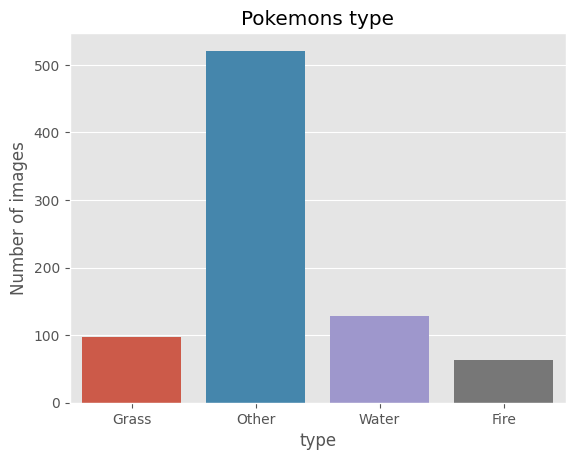

In [13]:
sns.countplot(x=pokemon.type,)
plt.title('Pokemons type')
plt.ylabel('Number of images')

## 2. Train Test Split
We perform a $80/20$ split on our data and use the dataclass object `ImageDataGenerator` to create $120 \times 120$ tiles which will be used as our inputs for the CNN. Each tile consists of 4 bands: Red, Green, Blue, and alpha (the opacity of the pixel) with its associated class label (Water, Grass, Fire, Other). The images are shuffled with a set seed. Furthermore, our data is set to a batch size of $32$ so it will decrease the amount of computational power needed for training our model.

In [14]:
train_datagenerator = ImageDataGenerator(
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    rescale=1./255, # Nomalization of data. Chose 255 because we code each pixel by rgba
    rotation_range=40, # Rotation to gain generalization
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    shear_range=.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode='nearest',
    validation_split=0.2)

# Generates batches for training (120 x 120 tiles)
train_generator = train_datagenerator.flow_from_dataframe(
    pokemon, 
    x_col='path', 
    y_col='type',
    target_size=(120, 120), 
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=32, 
    shuffle=True, 
    seed=5201314,
    subset='training')

# Generates batches for testing (120 x 120 tiles)
validation_generator = train_datagenerator.flow_from_dataframe(
    pokemon, 
    x_col='path',
    y_col='type',
    target_size=(120, 120),
    color_mode='rgba', 
    class_mode='categorical', 
    batch_size=4, 
    shuffle=True,
    seed=5201314, 
    subset='validation'
)

Found 648 validated image filenames belonging to 4 classes.
Found 161 validated image filenames belonging to 4 classes.


Here are 9 example images of the tiles of several pokemon images plotted out. Notice that the orientation of the images are also different from the original pokemon images provided.

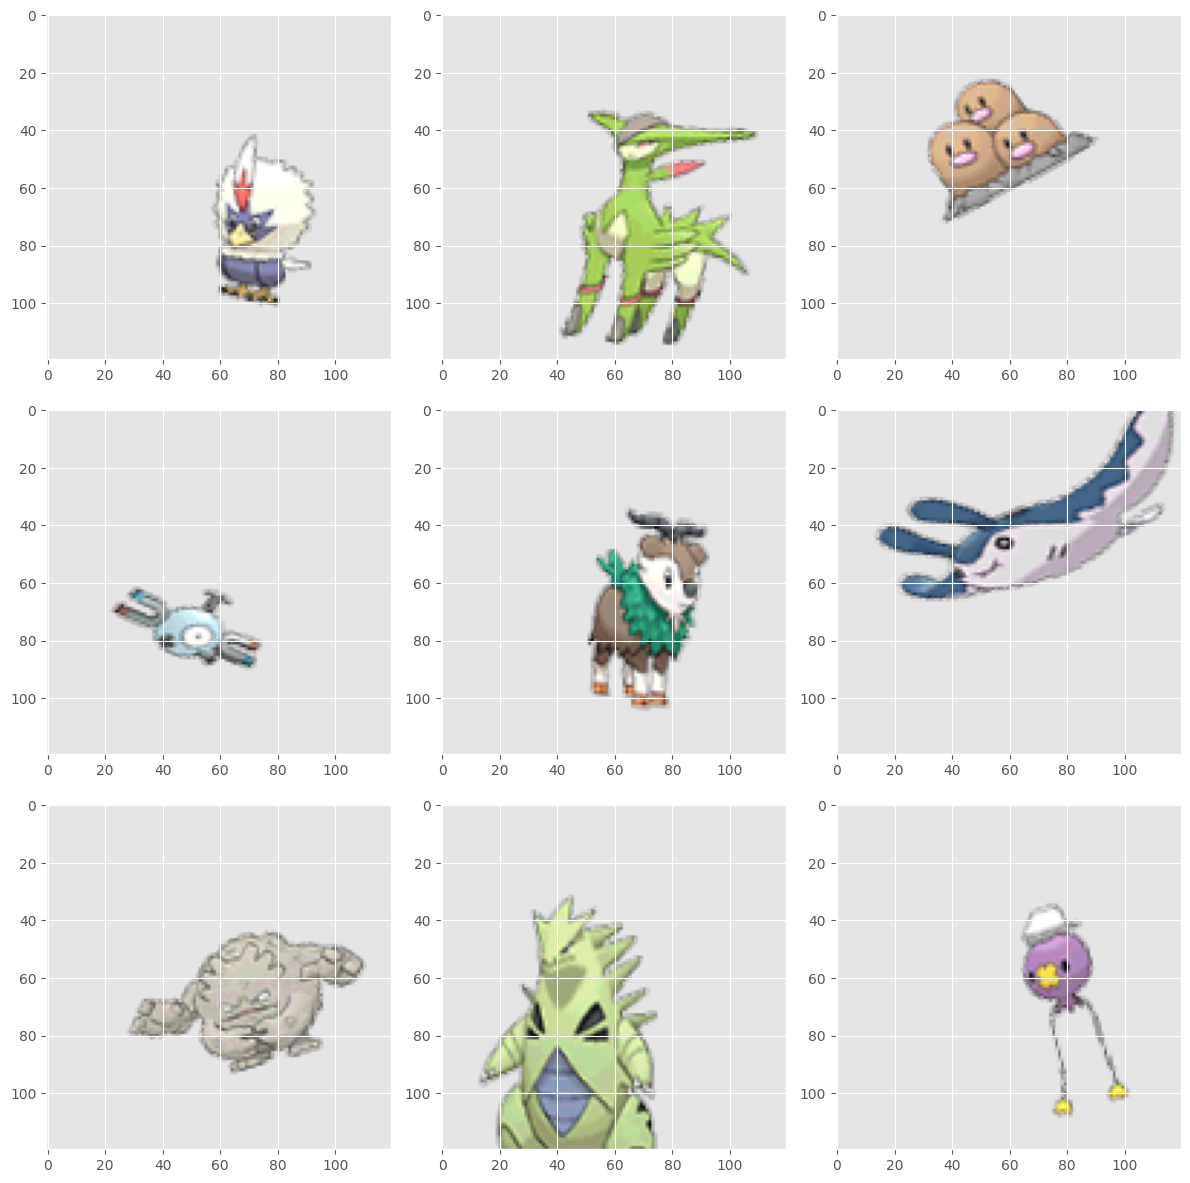

In [15]:
# Plot the processed images
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 3. Create Model
We now create our CNN model using `ks.models.Sequential()` with 3 convolutional layers. We use an initial dense layer which takes in our 4 band input of the $120 \times 120$ tile. We then perform three rounds of convolutions, each with a ReLU activation function followed by a layer of Max Pooling to help prevent over-fitting of our model. We then use a dropout layer to prevent all neurons in a layer from synchronously optimizing their weights. We then flatten our condensed array and use 2 more dense layers with a ReLU and softmax activation function. Finally, we compile our model and use an `adam` optimizer as it has been known to be an especially well-suited metric when utilized for multiclass classification problems.

In [16]:
# Model Initialization
model = ks.models.Sequential()

# Add a dense layer to process the images. Here 120 is the pixel number and 4 is the number of classes(Types) of Pokemons
model.add(ks.layers.Dense(4, input_shape=(120, 120, 4)))

# Add first convolutional layer 
model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

# Add second convolutional layer
model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))

# Add second convolutional layer
model.add(ks.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(2, 2))
model.add(ks.layers.Dropout(0.2))

# Flattens the imagesfrom high dimensions to low dimenions
model.add(ks.layers.Flatten())
        
model.add(ks.layers.Dense(1024, activation='relu'))

model.add(ks.layers.Dense(4, activation='softmax'))

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])

Here is the summary of our model with each layer containing information about its output shape and associated number of parameters. Note that our trainable model has a total of 44,678,872 parameters!

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120, 120, 4)       20        
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 64)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 256)       2

## 4. Compile Model
As stated before, we compile our model using the `adam` optimizer.

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

## 5. Fit the Model
We now fit the model to our training data over 50 epochs. Note that the progress bar is out of 21 since we are training the model in batch sizes of 32. We see from the training that both our training and validation accuracy increase after only a few epochs to a rough 81.17% and 74.53% respectively. 

In [29]:
history = model.fit_generator(
    train_generator, 
    epochs=50,
    validation_data = validation_generator,
)

Epoch 1/50


C:\Users\james\AppData\Local\Temp\ipykernel_39172\3144322892.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


21/21 [==============================] - 26s 1s/step - loss: 0.9026 - acc: 0.6790 - val_loss: 1.1831 - val_acc: 0.5590
Epoch 2/50
21/21 [==============================] - 26s 1s/step - loss: 0.9607 - acc: 0.6451 - val_loss: 1.1748 - val_acc: 0.5466
Epoch 3/50
21/21 [==============================] - 26s 1s/step - loss: 0.9334 - acc: 0.6651 - val_loss: 1.0643 - val_acc: 0.5776
Epoch 4/50
21/21 [==============================] - 27s 1s/step - loss: 0.9017 - acc: 0.6759 - val_loss: 1.0507 - val_acc: 0.6025
Epoch 5/50
21/21 [==============================] - 25s 1s/step - loss: 0.8905 - acc: 0.6667 - val_loss: 1.0530 - val_acc: 0.5776
Epoch 6/50
21/21 [==============================] - 26s 1s/step - loss: 0.9175 - acc: 0.6605 - val_loss: 1.0329 - val_acc: 0.6025
Epoch 7/50
21/21 [==============================] - 25s 1s/step - loss: 0.8925 - acc: 0.6651 - val_loss: 1.0694 - val_acc: 0.5963
Epoch 8/50
21/21 [==============================] - 25s 1s/step - loss: 0.8734 - acc: 0.6852 - val_lo

## 6. Summary

For better visualization, we plot out both the accuracies and losses for the training and validation set on two separate graphs over 50 epochs. We see from the model accuracy plot that .... . Furthermore, we see from the model loss plot that... .

Besides, to better understand the relationship between each type, we plot out a heatmap.

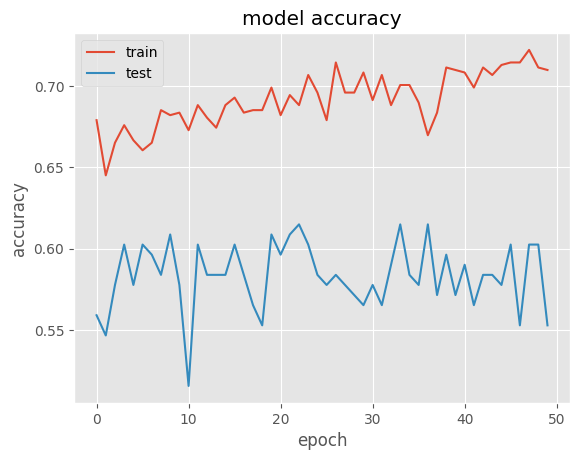

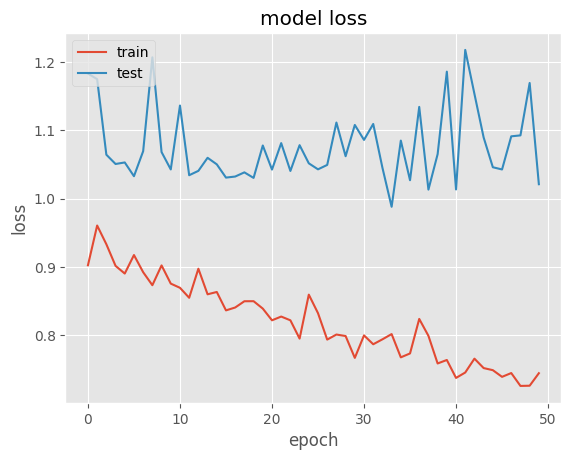

In [33]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

41/41 [==============================] - 2s 36ms/step


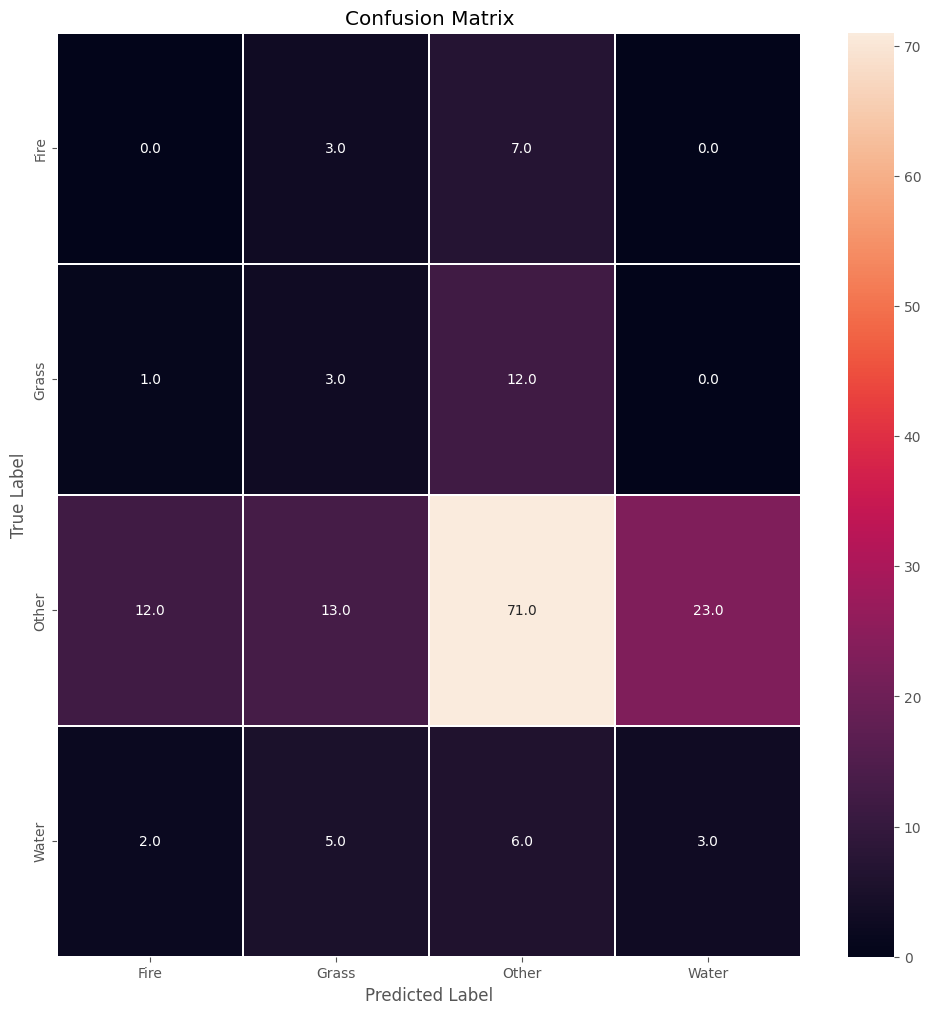

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, validation_generator.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(validation_generator.class_indices)
ax.yaxis.set_ticklabels(validation_generator.class_indices)
plt.title("Confusion Matrix")
plt.show()